# 1d !Kung

 /home/mike/Documents/Research/dp4gp/dp4gp/dp4gp.py:155: RuntimeWarning:covariance is not positive-semidefinite.
 /home/mike/Documents/Research/dp4gp/dp4gp/dp4gp.py:343: RuntimeWarning:divide by zero encountered in log
 /home/mike/Documents/Research/dp4gp/dp4gp/dp4gp.py:418: RuntimeWarning:covariance is not positive-semidefinite.


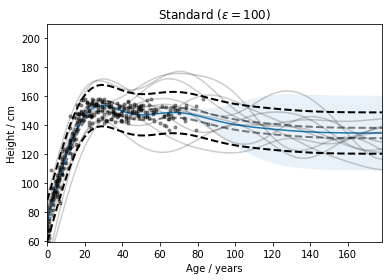

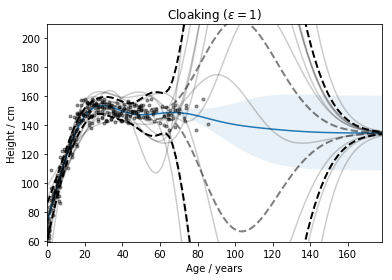

In [1]:
from dp4gp import datasets
from dp4gp import dp4gp
from dp4gp import histogram
from dp4gp.utils import dp_normalise, dp_unnormalise
import numpy as np
import GPy
import matplotlib.pyplot as plt
%matplotlib inline

def makeplot(method, epsilon, title, filename):
    sens = 100.0 #sensitivity
    delta = 0.01

    #Load and normalise dataset
    kung = datasets.load_kung() 
    y,ac_sens,norm_params = dp_normalise(kung[kung[:,3]==0,0:1],sens)
    X = kung[kung[:,3]==0,2:3]
    Xtest = np.arange(-40,140,3)[:,None]

    #Create GP model
    kern = GPy.kern.RBF(1.0,lengthscale=25.0,variance=1.0)
    model = GPy.models.GPRegression(X,y,kern,normalizer=None)
    model.Gaussian_noise = 0.3

    #Define DP4GP object
    dpgp = method(model,ac_sens,epsilon,delta)

    #Plot and save figure
    plt.figure(figsize=[6,4])
    dpgp.plot(plot_data = True,extent_lower={0:0},extent_upper={0:180},Nits=100,norm_params=norm_params,confidencescale=[1.0,0.25])
    plt.ylim([norm_params['mean']-sens*0.75,norm_params['mean']+sens*0.75])
    plt.ylabel('Height / cm')
    plt.xlabel('Age / years')
    plt.title(title)
    plt.savefig(filename)
    

makeplot(dp4gp.DPGP_normal_prior,100.0,'Standard ($\\varepsilon = 100$)','kung_standard.pdf')
makeplot(dp4gp.DPGP_cloaking,1.0,'Cloaking ($\\varepsilon = 1$)','kung_cloaking.pdf')

# Houseprices

In [28]:
h = get_house_prices()

Creating postcode database in geo.db
geo.db exists, skipping
Using presampled dataset.
Loaded property prices.


Creating postcode database in geo.db
geo.db exists, skipping
Using presampled dataset.
Loaded property prices.
*
.Stopped before convergence


 /home/mike/Documents/Research/dp4gp/dp4gp/dp4gp.py:347: RuntimeWarning:divide by zero encountered in log
 /home/mike/Documents/Research/dp4gp/dp4gp/dp4gp.py:422: RuntimeWarning:covariance is not positive-semidefinite.
 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning:invalid value encountered in sqrt


[[473024.09999999998, 120080.10000000001], [583887.95999999996, 233805.35999999999]]


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


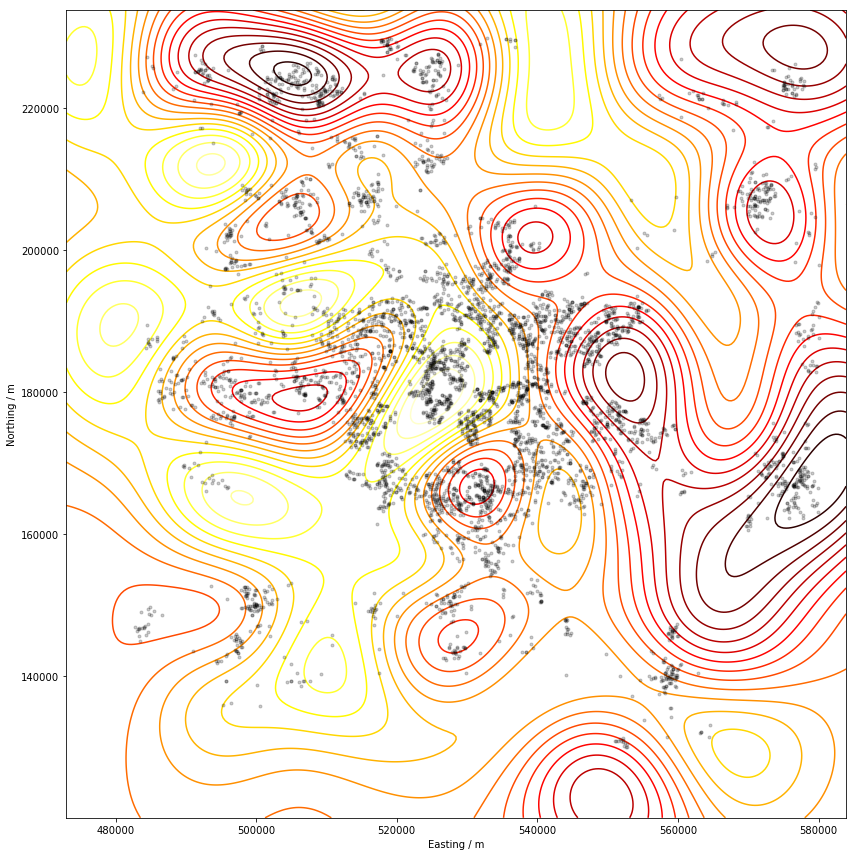

In [5]:
from dp4gp import datasets
from dp4gp import dp4gp
from dp4gp import histogram
from dp4gp.utils import dp_normalise, dp_unnormalise
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt
%matplotlib inline

def get_house_prices():
    datasets.prepare_preloaded_prices('price_today_dataset10k.csv', col_list=[], since=2013, boundingbox=[480e3, 130e3, 580e3, 230e3], N=5000)
    dataset = pd.read_csv('price_today_dataset10k.csv') #london, 10k purchases
    inputs = np.vstack([dataset['easting'].values,dataset['northing'].values]).T
    ys = dataset['price'].values
    return inputs, ys

eps = 1.0
delta = 0.05
sens = 400e3
inputs, raw_ys = get_house_prices()
ys,ac_sens,norm_params = dp_normalise(raw_ys,sens,clip='median')

kernvar = 1.0
kern_ls = np.array([1,1])*10e3
noise = 1.0


rbf = GPy.kern.RBF(inputs.shape[1],kernvar, kern_ls,ARD=True)
mod = GPy.models.GPRegression(inputs,ys[:,None],rbf)
mod.Gaussian_noise = noise
dpgp = dp4gp.DPGP_cloaking(mod,sens,eps,delta)
dpgp.plot(Nits=1,norm_params=norm_params,plotGPvar=False,plot_data=True,steps=20,verbose=True)
plt.xlabel('Easting / m')
plt.ylabel('Northing / m')
#plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.savefig('houseprices2.pdf')